In [1]:
using Revise
using Pkg
using RCall
using DataFrames
R"""
library(ggplot2)
library(fitdistrplus)
library(patchwork)

"""
Pkg.activate("/mnt/raid/covid-phylogeny/scripts/julia_modules/JuliaClusterAndTreeTools")
using JuliaClusterAndTreeTools
using Statistics



┌ Warning: RCall.jl: Loading required package: MASS
│ Loading required package: survival
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172
┌ Warning: RCall.jl: 
│ Attaching package: ‘patchwork’
│ 
│ The following object is masked from ‘package:MASS’:
│ 
│     area
│ 
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172
  Activating project at `/mnt/raid/covid-phylogeny/scripts/julia_modules/JuliaClusterAndTreeTools`


In [2]:
in_file_name = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000.fasta.gz"
keepPositionsFraction = 0.8
output_file_name = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_filtered.fasta.gz"
columns_with_excess_N = "/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_filtered_skiped_rows.txt"

"/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000_filtered_skiped_rows.txt"

In [3]:
aln = JuliaClusterAndTreeTools.Alignment(in_file_name)
#aln = JuliaClusterAndTreeTools.Alignment("/mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade.fasta.gz")
print("Alignment parsed")



Reading aligment /mnt/raid/covid-phylogeny/audines11/rez/lineages/BA.2/alignment_nextclade_1000.fasta.gz



Alignment parsed


Reading alignment finished, 193 sequences were skipped due to atypical symbols



In [4]:
dc = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_collumnwise(aln)
dr = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_rowwise(aln)
print("calculated..")

Doing transposition...
Done. Converting to a data frame...
Done
Doing transposition...
Done. Converting to a data frame...
calculated..

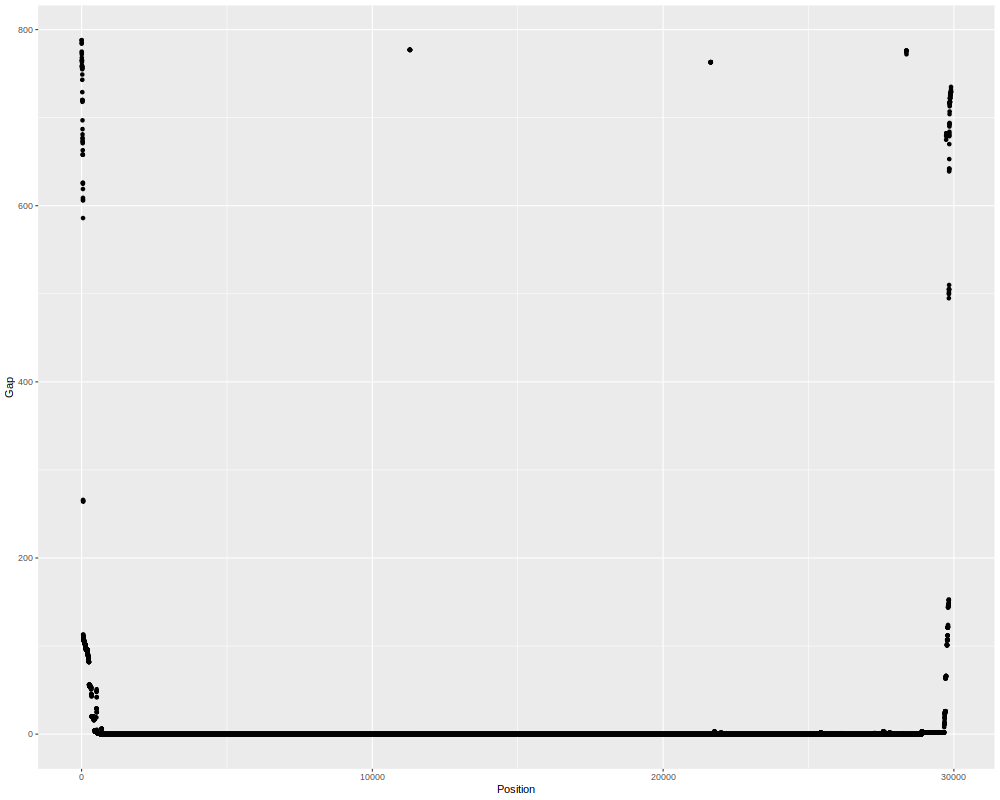

RObject{VecSxp}


In [5]:
@rput dc
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
p <- ggplot(data=dc) + geom_point(aes(x=Position,y=Gap))
p
"""

In [6]:
size(dc)[1]

29903

In [7]:
# remove tails down to median value
median_Gap = median(dc.Gap)
starti = undef
endi = undef
lenAln = size(dc)[1]
for i in  1:lenAln
    if dc.Gap[i] ==0
        starti = i
        break
    end
end

for i in  1:lenAln
    ie = lenAln-i+1
    if dc.Gap[ie] ==0
        endi = ie
        break
    end
end
println(starti)
println(endi)
JuliaClusterAndTreeTools.sub_alignment!(aln,starti:endi)

645
28893


794×28249 Matrix{BioSymbols.DNA}:
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T  …  DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T  …  DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T  …  DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 ⋮               

Doing transposition...
Done. Converting to a data frame...
Done
Doing transposition...
Done. Converting to a data frame...


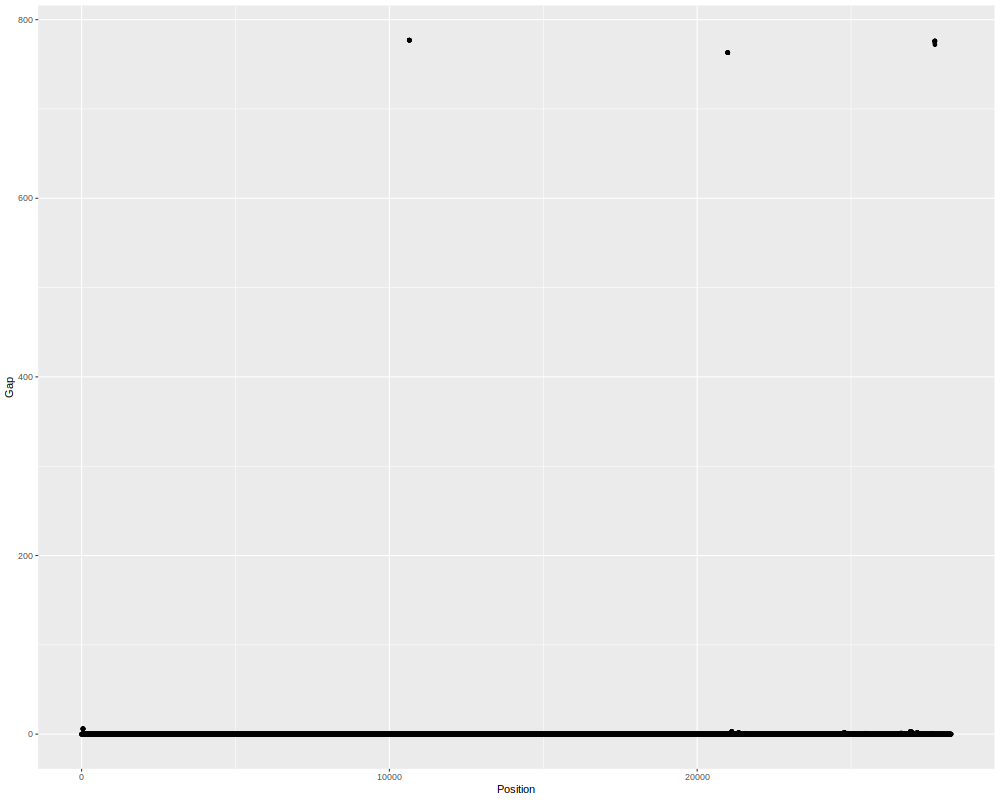

RObject{VecSxp}


In [8]:
dc = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_collumnwise(aln)
dr = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_rowwise(aln)
@rput dc
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
p <- ggplot(data=dc) + geom_point(aes(x=Position,y=Gap))
p
"""

Distributin of N across sequence

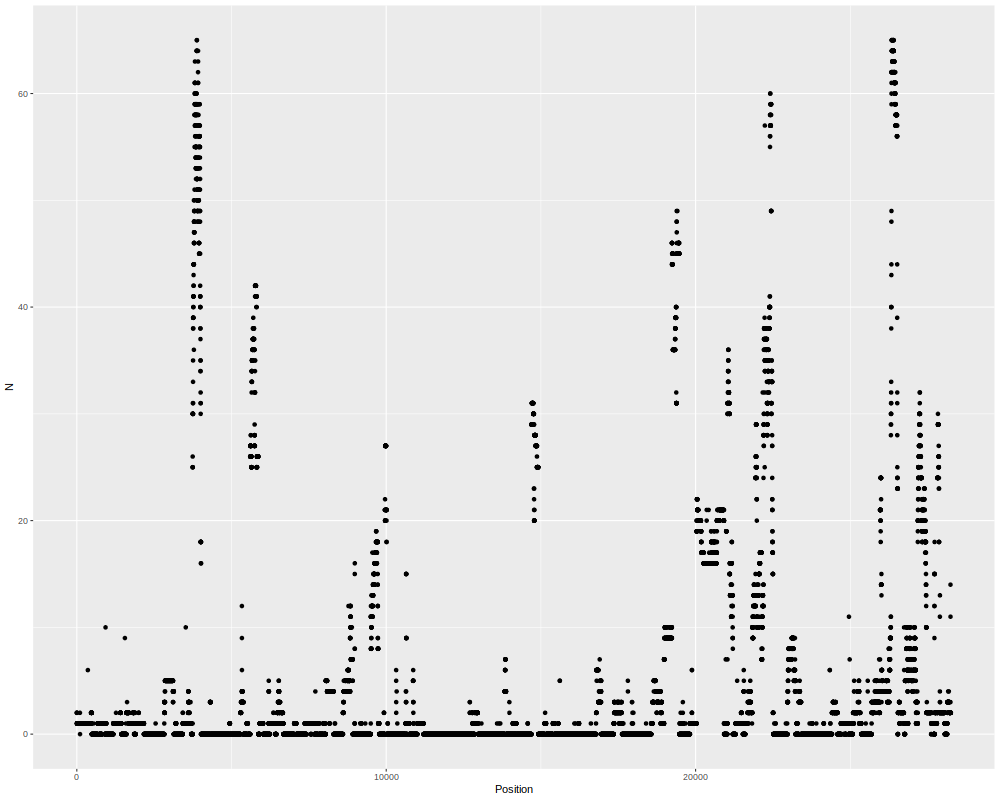

RObject{VecSxp}


In [9]:
print("Distributin of N across sequence")
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
pn1 <- ggplot(data=dc) + geom_point(aes(x=Position,y=N))
pn1
"""

Will remove alignment columns with more than 5.0 N Left with 23655 columns, 0.8373747743282948 of initial sequences 

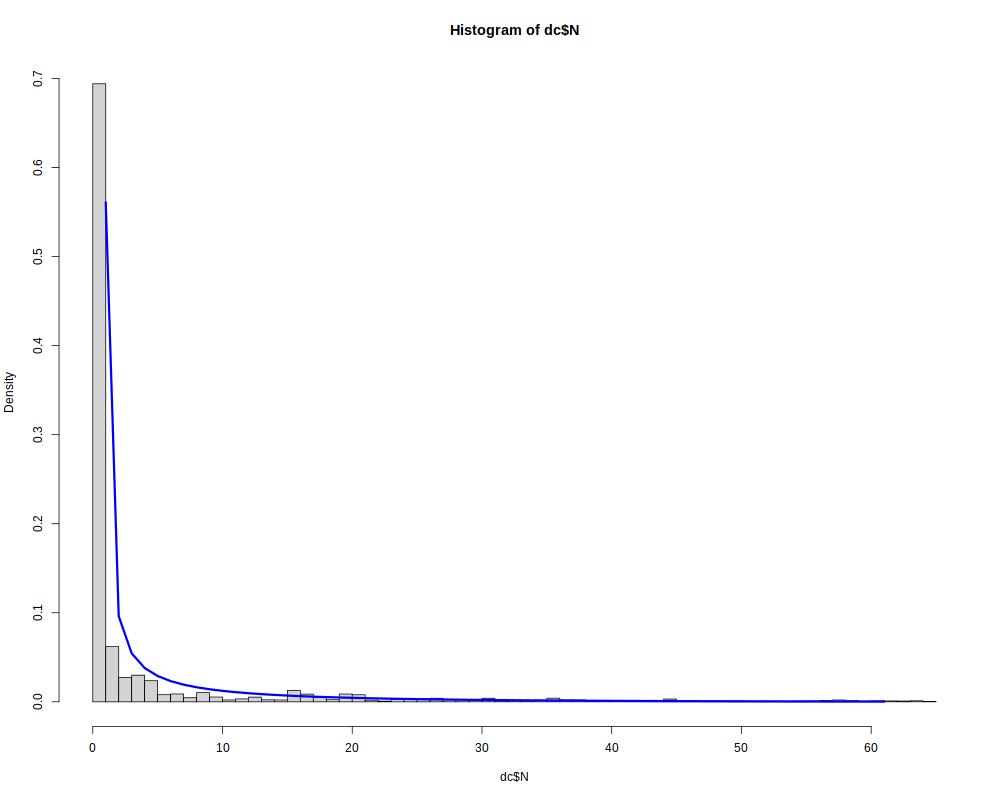

In [10]:
#remove out lier positions based on N
@rput keepPositionsFraction
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))



R"""
library(fitdistrplus)
fit <- fitdist(dc$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
fitD <- dnbinom(0:60, size=size, mu=mu)
hist(dc$N, prob=TRUE, breaks=60)
lines(fitD, lwd="3", col="blue")
maxNlimit = qnbinom(keepPositionsFraction, mu = mu, size = size)
"""
@rget maxNlimit
leftNini = nrow(dc)
dcf1 = filter(row -> row.N <= maxNlimit, dc)
print("Will remove alignment columns with more than $maxNlimit N ")
leftN = nrow(dcf1)
leftP = leftN/leftNini
print("Left with $leftN columns, $leftP of initial sequences ")

In [11]:
size(aln.M[:,dcf1.Position])
aln.M = aln.M[:,dcf1.Position]


794×23655 Matrix{BioSymbols.DNA}:
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T  …  DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T  …  DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T  …  DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 DNA_G  DNA_T  DNA_A  DNA_A  DNA_T     DNA_T  DNA_C  DNA_T  DNA_C  DNA_C
 ⋮               

Doing transposition...oved high N content columnsCounted 1000 columns
Done. Converting to a data frame...
Done
Doing transposition...
Done. Converting to a data frame...


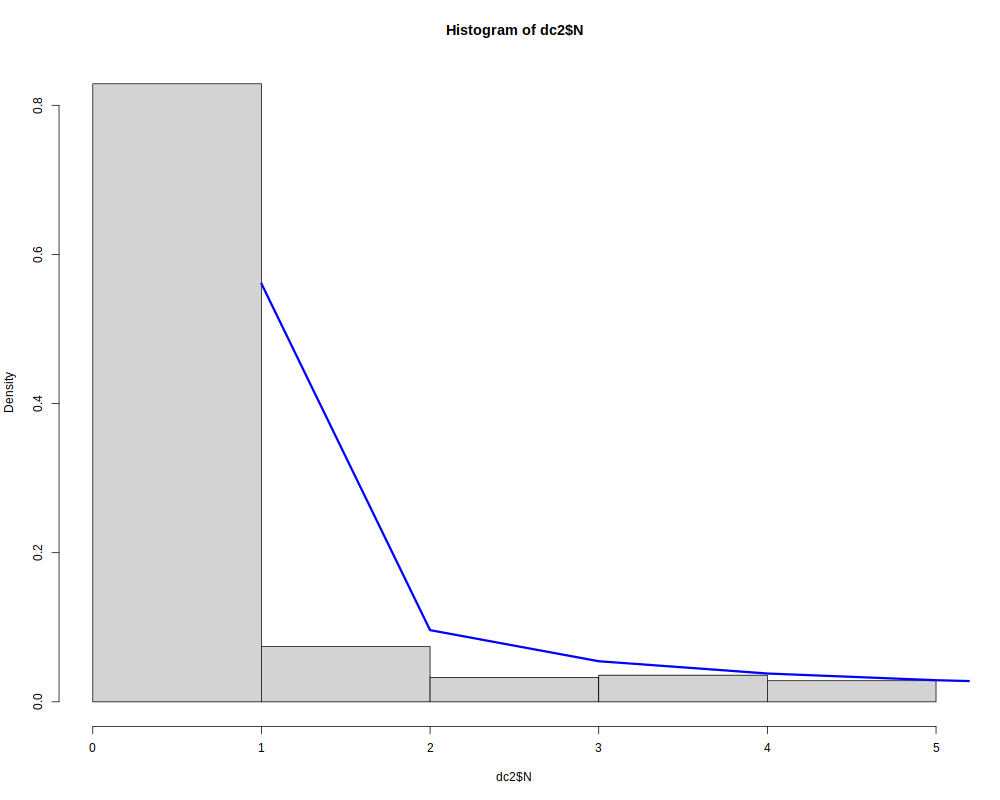

RObject{NilSxp}
NULL


In [12]:
print("Test sequence with removed high N content columns")
dc2 = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_collumnwise(aln)
dr2 = JuliaClusterAndTreeTools.get_statistics_on_Gaps_Ns_rowwise(aln)
@rput dc2
R"""
library(fitdistrplus)
fit <- fitdist(dc2$N, "nbinom")
mu = as.double(fit$estimate["mu"][[1]])
size = as.double(fit$estimate["size"][[1]])
hist(dc2$N, prob=TRUE, n=4)
lines(fitD, lwd="3", col="blue")
"""

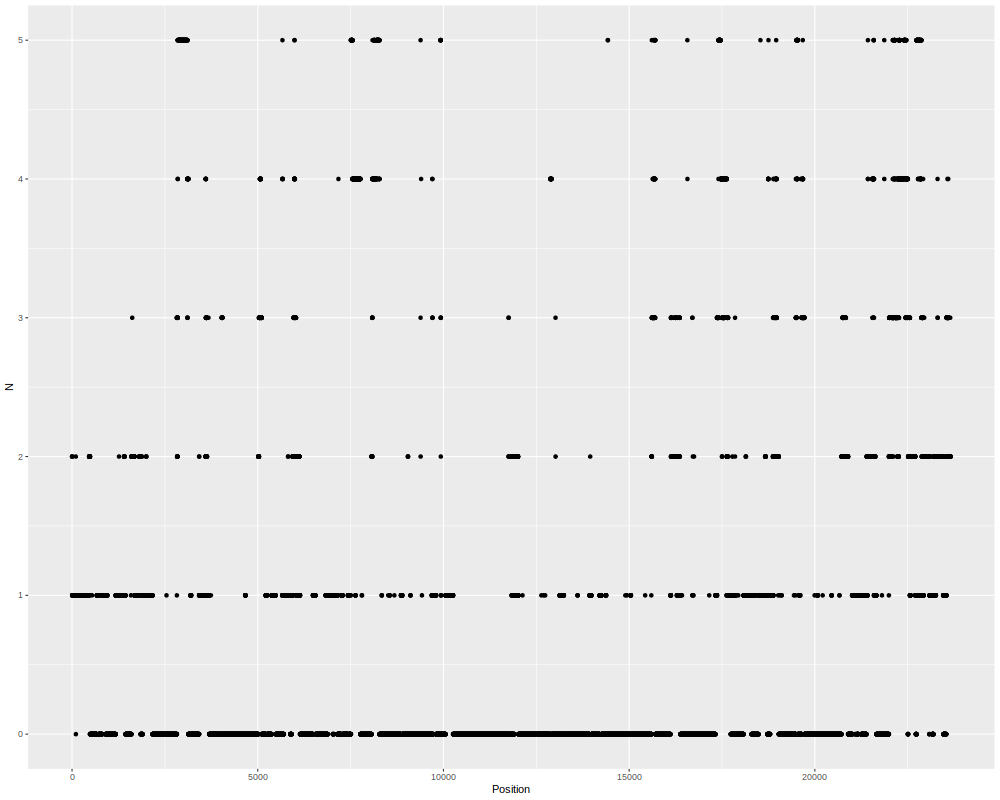

RObject{VecSxp}


In [13]:
@rput dc2
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 1000, :height => 800))
R"""
pn2 <- ggplot(data=dc2) + geom_point(aes(x=Position,y=N))
pn2
"""

┌ Warning: RCall.jl: Warning: The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
│ ℹ Please use `after_stat(count)` instead.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
│ `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
└ @ RCall /home/user1/.julia/packages/RCall/Wyd74/src/io.jl:172


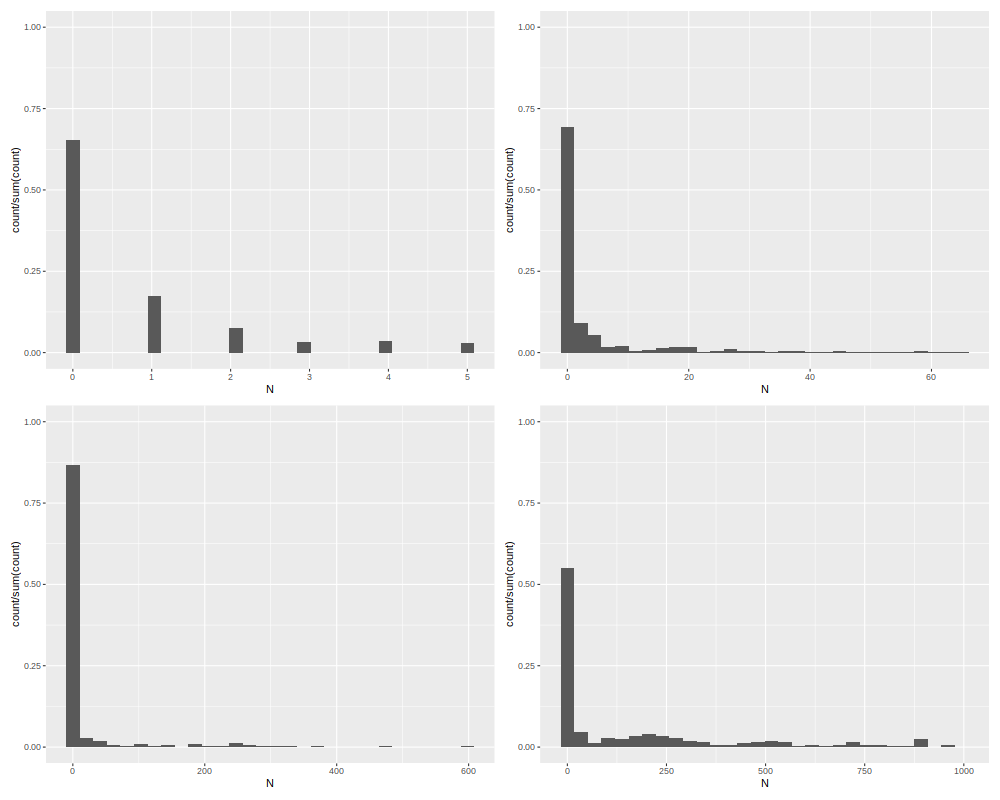

RObject{VecSxp}


In [14]:
@rput dc dc2 dr dr2
R"""
pini<-ggplot(dc, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)
p<-ggplot(dc2, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)

pinir<-ggplot(dr, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)
pr<-ggplot(dr2, aes(x=N)) + 
    stat_bin(aes(y=..count../sum(..count..))) + ylim(0,1.0)

(p|pini)/(pr|pinir)
"""

In [15]:
dr2_N0 = filter(row -> row.N ==0, dr2)
print("Kept ",round(size(dr2_N0)[1]/size(dr2)[1],digits=2)," ",size(dr2_N0)[1])

Kept 0.78 620

In [16]:
#get the final set odf sequences
JuliaClusterAndTreeTools.sub_alignment!(aln, dr2_N0.NR)

Dict{String, Int64} with 620 entries:
  "France/PDL-IPP14448/2022"                => 20
  "France/OCC-GENBIO-E05GN0311402/2022"     => 137
  "USA/MA-Broad-CRSP_G5B3HZ26OHERRLOK/2022" => 509
  "England/MILK-3AA049A/2022"               => 352
  "Switzerland/ZH-ETHZ-36792922/2022"       => 571
  "Germany/RP-RKI-I-698610/2022"            => 111
  "Switzerland/GR-ETHZ-674219/2022"         => 194
  "Japan/IC-5814/2022"                      => 478
  "England/LSPA-3B893E4/2022"               => 520
  "Germany/BW-RKI-I-637936/2022"            => 552
  "Germany/BY-RKI-I-634346/2022"            => 558
  "England/NEWC-39F3DDA/2022"               => 434
  "Denmark/DCGC-471673/2022"                => 87
  "Germany/NW-RKI-I-629937/2022"            => 399
  "Denmark/DCGC-343195/2022"                => 268
  "England/QEUH-3C88DB9/2022"               => 26
  "Japan/TKYkbm16593/2022"                  => 366
  "Netherlands/UT-RIVM-95919/2022"          => 145
  "England/ALDP-39C970C/2022"               => 

In [18]:
JuliaClusterAndTreeTools.write_to_fasta(aln, output_file_name)

LoadError: UndefVarError: str not defined

dr2_N0